In [1]:
!pip install -q piq
!pip install -q diffusers

In [58]:
import torch
import torchvision
from torchvision.datasets import VisionDataset
from collections import defaultdict
from diffusers import DDPMPipeline
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Subset
from torchvision.utils import save_image
import random
import numpy as np
import os
import shutil
from tqdm.auto import tqdm
from piq import KID, FID, MSID

In [3]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# MNIST

In [5]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [70]:
def collator_mnist(batch):
  batch_dict = defaultdict(list)
  for item in batch:
      batch_dict['images'].append(torch.concatenate((item[0], item[0], item[0]), axis=0).unsqueeze(0))
      batch_dict['targets'].append(torch.tensor(item[1]).unsqueeze(0))

  return {'images': torch.concatenate(batch_dict['images'], axis=0), 'targets': torch.concatenate(batch_dict['targets'], axis=0)}

In [7]:
batch_size = 100

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size,
                                      shuffle=False, num_workers=0, collate_fn=collator_mnist)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


model_index.json:   0%|          | 0.00/180 [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/455M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/785 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /home/jovyan/.cache/huggingface/hub/models--dimpo--ddpm-mnist/snapshots/f1705b4261ad5f60ffa368bfca60569110f5d6f4/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /home/jovyan/.cache/huggingface/hub/models--dimpo--ddpm-mnist/snapshots/f1705b4261ad5f60ffa368bfca60569110f5d6f4/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/1000 [00:00<?, ?it/s]

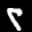

In [8]:
pipeline = DDPMPipeline.from_pretrained('dimpo/ddpm-mnist').to(device)
image = pipeline().images[0]
image

In [9]:
class GeneratedImageDataset(VisionDataset):
    def __init__(self, images, labels, transform=None):
        super().__init__()
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [10]:
generated_images = []
generated_labels = []

for i, sample_dict in tqdm(enumerate(testloader)):
    images = sample_dict['images']
    labels = sample_dict['targets']
    images_ddpm = pipeline(batch_size=batch_size, num_inference_steps=20, output_type="numpy").images

    tensor_images = torch.stack([torch.as_tensor(img_arr) for img_arr in images_ddpm])
    tensor_labels = torch.stack([torch.as_tensor(label) for label in labels])
    generated_images.append(tensor_images)
    generated_labels.append(tensor_labels)

generated_tensors = torch.cat(list(map(lambda x: x.permute(0,3,1,2), generated_images)), axis=0)
generated_labels = torch.cat(generated_labels, axis=0)

0it [00:00, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [11]:
def collator(batch):
  batch_dict = defaultdict(list)
  for item in batch:
      batch_dict['images'].append(item[0].unsqueeze(0))
      batch_dict['targets'].append(torch.tensor([item[1]]))

  return {'images': torch.concatenate(batch_dict['images'], axis=0), 'targets': torch.concatenate(batch_dict['targets'], axis=0)}

In [12]:
generated_dataset = GeneratedImageDataset(generated_tensors, generated_labels)
synt_dl = DataLoader(generated_dataset, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collator)

In [13]:
@torch.no_grad()
def calc_metrics(first_dl, second_dl):

    fid_metric = FID()
    first_feats = fid_metric.compute_feats(first_dl)
    second_feats = fid_metric.compute_feats(second_dl)
    fid: torch.Tensor = fid_metric(first_feats, second_feats)

    # Use FID class to compute FID score from image features, pre-extracted from some feature extractor network
    # fid: torch.Tensor = FID()(x_features, y_features)
    print(f"FID: {fid:0.4f}")

    # If image features are not available, extract them using compute_feats of FID class.
    # Please note that compute_feats consumes a data loader of predefined format.

    # Use KID class to compute KID score from image features, pre-extracted from some feature extractor network:
    kid: torch.Tensor = KID()(first_feats, second_feats)
    print(f"KID: {kid:0.4f}")

    # Use MSID class to compute MSID score from image features, pre-extracted from some feature extractor network:
    msid: torch.Tensor = MSID(niters=100)(first_feats, second_feats)
    print(f"MSID: {msid:0.4f}")

In [14]:
calc_metrics(testloader, synt_dl)

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/opt/conda/lib/python3.11/site-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(
Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /home/jovyan/.cache/t

FID: 24.3191
KID: 0.0148
MSID: 8.6028


## CIFAR10

In [15]:
from torch.utils.data import Sampler
from collections import defaultdict

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /home/jovyan/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80: Error no file named diffusion_pytorch_model.safetensors found in directory /home/jovyan/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/1000 [00:00<?, ?it/s]

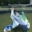

In [81]:
pipeline = DDPMPipeline.from_pretrained("google/ddpm-cifar10-32").to(device)
image = pipeline().images[0]
image

In [82]:
transform = transforms.Compose([
    transforms.ToTensor()
  ])

batch_size = 100

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0, collate_fn=collator)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0, collate_fn=collator)

Files already downloaded and verified
Files already downloaded and verified


In [83]:
generated_images = []
generated_labels = []

for i, sample_dict in tqdm(enumerate(testloader)):
    images = sample_dict['images']
    labels = sample_dict['targets']
    images_ddpm = pipeline(batch_size=batch_size, num_inference_steps=20, output_type="numpy").images

    tensor_images = torch.stack([torch.as_tensor(img_arr) for img_arr in images_ddpm])
    tensor_labels = torch.stack([torch.as_tensor(label) for label in labels])
    generated_images.append(tensor_images)
    generated_labels.append(tensor_labels)

0it [00:00, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [19]:
generated_images_train = []
generated_labels_train = []

for i, sample_dict in tqdm(enumerate(trainloader)):
    images = sample_dict['images']
    labels = sample_dict['targets']
    images_ddpm = pipeline(batch_size=batch_size, num_inference_steps=20, output_type="numpy").images

    tensor_images = torch.stack([torch.as_tensor(img_arr) for img_arr in images_ddpm])
    tensor_labels = torch.stack([torch.as_tensor(label) for label in labels])
    generated_images_train.append(tensor_images)
    generated_labels_train.append(tensor_labels)

0it [00:00, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [20]:
from torchvision.models import vgg16, VGG16_Weights

class VGG16_FeaturesExtractor(torch.nn.Module):
    def __init__(self, weights=VGG16_Weights.DEFAULT):
        super().__init__()

        self.feature_extractor = vgg16(weights=VGG16_Weights.DEFAULT).features
        self.avgpool = torch.nn.AdaptiveAvgPool2d(output_size=(1, 1))

    def forward(self, x):
        output = []

        x = self.feature_extractor(x)
        x = self.avgpool(x).squeeze()
        output.append(x)

        return output

In [84]:
import time

@torch.no_grad()
def calc_metrics(first_dl: DataLoader, second_dl: DataLoader):
    # Compute FID
    start_time = time.time()
    fid_metric = FID()
    first_feats = fid_metric.compute_feats(loader=first_dl, feature_extractor=VGG16_FeaturesExtractor(), device='cuda')
    second_feats = fid_metric.compute_feats(loader=second_dl, feature_extractor=VGG16_FeaturesExtractor(), device='cuda')
    fid = fid_metric(first_feats, second_feats)
    metric_time['FID'].append(time.time() - start_time)
    metric_dict['FID'].append(fid.item())  # Store the FID score as a float
    print(f"FID: {fid:0.4f}, Time: {metric_time['FID'][-1]:0.4f} seconds")

    # Compute KID
    start_time = time.time()
    kid = KID()(first_feats, second_feats)
    metric_time['KID'].append(time.time() - start_time)
    metric_dict['KID'].append(kid.item())  # Store the KID score as a float
    print(f"KID: {kid:0.4f}, Time: {metric_time['KID'][-1]:0.4f} seconds")

    # Compute MSID
    start_time = time.time()
    msid = MSID(niters=100)(first_feats, second_feats)
    metric_time['MSID'].append(time.time() - start_time)
    metric_dict['MSID'].append(msid.item())  # Store the MSID score as a float
    print(f"MSID: {msid:0.4f}, Time: {metric_time['MSID'][-1]:0.4f} seconds")

In [85]:
num_batches = np.linspace(10, len(testloader), 10).astype(int)
num_batches

array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100])

In [88]:
metric_dict = defaultdict(list)
metric_time = defaultdict(list)

for processed_batches in tqdm(num_batches):
    processed_indices = list(range(processed_batches*batch_size))
    subset = Subset(testloader.dataset, processed_indices)
    sub_testloader = DataLoader(subset, batch_size=testloader.batch_size, shuffle=False, num_workers=testloader.num_workers, collate_fn=collator)

    generated_tensors_subset = torch.cat(list(map(lambda x: x.permute(0,3,1,2), generated_images[:processed_batches])), axis=0)
    generated_labels_subset = torch.cat(generated_labels[:processed_batches], axis=0)
    generated_dataset = GeneratedImageDataset(generated_tensors_subset, generated_labels_subset)
    synt_dl = DataLoader(generated_dataset, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collator)
    
    calc_metrics(sub_testloader, synt_dl)

  0%|          | 0/10 [00:00<?, ?it/s]

FID: 274.3475, Time: 4.2109 seconds
KID: 0.9721, Time: 0.1519 seconds
MSID: 51.7132, Time: 0.6031 seconds
FID: 276.8653, Time: 4.3229 seconds
KID: 1.0066, Time: 0.1579 seconds
MSID: 30.2863, Time: 2.7202 seconds
FID: 272.7924, Time: 4.7128 seconds
KID: 0.9990, Time: 0.1708 seconds
MSID: 31.6014, Time: 3.6885 seconds
FID: 272.6963, Time: 4.8749 seconds
KID: 1.0009, Time: 0.1757 seconds
MSID: 30.6205, Time: 6.9700 seconds
FID: 273.9528, Time: 5.4795 seconds
KID: 1.0042, Time: 0.1814 seconds
MSID: 30.3344, Time: 7.2363 seconds
FID: 272.7041, Time: 5.6137 seconds
KID: 1.0024, Time: 0.2131 seconds
MSID: 32.6959, Time: 8.8895 seconds
FID: 273.1902, Time: 6.2828 seconds
KID: 1.0005, Time: 0.3537 seconds
MSID: 27.6226, Time: 12.9355 seconds
FID: 273.5539, Time: 6.4987 seconds
KID: 1.0018, Time: 0.3997 seconds
MSID: 30.2581, Time: 16.7187 seconds
FID: 273.0470, Time: 7.0351 seconds
KID: 1.0021, Time: 0.5353 seconds
MSID: 26.1120, Time: 21.8643 seconds
FID: 271.5404, Time: 7.1138 seconds
KID: 0.

In [36]:
num_batches_train = np.linspace(10, len(trainloader), 10).astype(int)
num_batches_train

array([ 10,  64, 118, 173, 227, 282, 336, 391, 445, 500])

In [37]:
num_batches_train = np.insert(num_batches_train, 2, 100)
num_batches_train

array([ 10,  64, 100, 118, 173, 227, 282, 336, 391, 445, 500])

In [38]:
metric_dict_train = defaultdict(list)
metric_time_train = defaultdict(list)

for processed_batches in tqdm(num_batches_train):
    processed_indices = list(range(processed_batches*batch_size))
    subset = Subset(trainloader.dataset, processed_indices)
    sub_trainloader = DataLoader(subset, batch_size=trainloader.batch_size, shuffle=False, num_workers=trainloader.num_workers, collate_fn=collator)

    generated_tensors_train_subset = torch.cat(list(map(lambda x: x.permute(0,3,1,2), generated_images_train[:processed_batches])), axis=0)
    generated_labels_train_subset = torch.cat(generated_labels_train[:processed_batches], axis=0)
    generated_dataset_train = GeneratedImageDataset(generated_tensors_train_subset, generated_labels_train_subset)
    synt_dl = DataLoader(generated_dataset_train, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collator)
    
    calc_metrics(sub_trainloader, synt_dl)

  0%|          | 0/11 [00:00<?, ?it/s]

FID: 271.4487, Time: 3.9207 seconds
KID: 0.9642, Time: 0.0030 seconds
MSID: 35.3937, Time: 0.5968 seconds
FID: 268.3485, Time: 4.3249 seconds
KID: 0.9829, Time: 0.2002 seconds
MSID: 29.5988, Time: 14.7385 seconds
FID: 267.7017, Time: 6.7224 seconds
KID: 0.9860, Time: 0.5371 seconds
MSID: 26.1608, Time: 33.8759 seconds
FID: 267.6953, Time: 5.7308 seconds
KID: 0.9833, Time: 0.5623 seconds
MSID: 26.0902, Time: 21.7143 seconds
FID: 268.0610, Time: 8.0176 seconds
KID: 0.9865, Time: 1.1259 seconds
MSID: 26.7561, Time: 45.1628 seconds
FID: 268.4839, Time: 8.5622 seconds
KID: 0.9888, Time: 2.0432 seconds
MSID: 25.5099, Time: 61.7758 seconds
FID: 268.2661, Time: 9.5848 seconds
KID: 0.9886, Time: 3.1588 seconds
MSID: 23.8066, Time: 106.3346 seconds
FID: 268.4253, Time: 8.3893 seconds
KID: 0.9893, Time: 4.4495 seconds
MSID: 22.8654, Time: 149.8331 seconds
FID: 268.2401, Time: 10.6187 seconds
KID: 0.9883, Time: 5.7291 seconds
MSID: 22.3707, Time: 186.9814 seconds
FID: 268.2868, Time: 10.7642 secon

In [51]:
metric_dict_train = [
    {'FID': 271.4487, 'KID': 0.9642, 'MSID': 35.3937},
    {'FID': 268.3485, 'KID': 0.9829, 'MSID': 29.5988},
    {'FID': 267.7017, 'KID': 0.9860, 'MSID': 26.1608},
    {'FID': 267.6953, 'KID': 0.9833, 'MSID': 26.0902},
    {'FID': 268.0610, 'KID': 0.9865, 'MSID': 26.7561},
    {'FID': 268.4839, 'KID': 0.9888, 'MSID': 25.5099},
    {'FID': 268.2661, 'KID': 0.9886, 'MSID': 23.8066},
    {'FID': 268.4253, 'KID': 0.9893, 'MSID': 22.8654},
    {'FID': 268.2401, 'KID': 0.9883, 'MSID': 22.3707},
    {'FID': 268.2868, 'KID': 0.9888, 'MSID': 21.6359},
    {'FID': 268.4557, 'KID': 0.9904, 'MSID': 21.8244}
]

metric_dict_converted = {
    'FID': [],
    'KID': [],
    'MSID': []
}

for entry in metric_dict_train:
    metric_dict_converted['FID'].append(entry['FID'])
    metric_dict_converted['KID'].append(entry['KID'])
    metric_dict_converted['MSID'].append(entry['MSID'])

metric_dict_train = metric_dict_converted

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

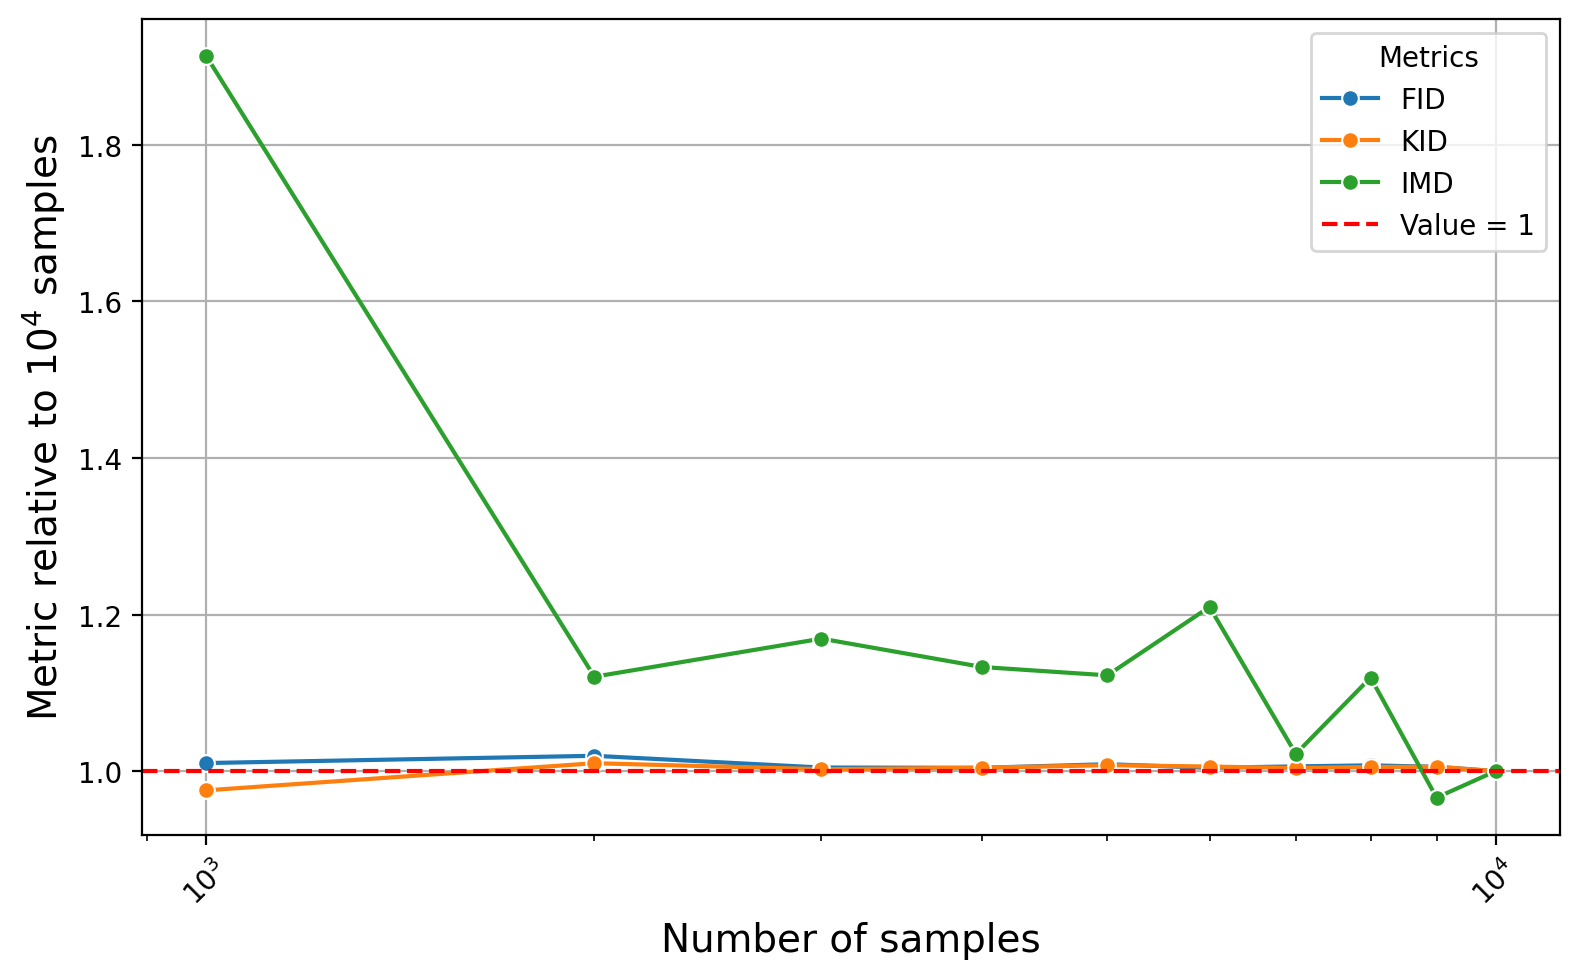

In [89]:
plt.figure(figsize=(8, 5), dpi=200)

sns.lineplot(x=num_batches*100, y=np.array(metric_dict["FID"]) / metric_dict["FID"][-1], label='FID', marker='o')
sns.lineplot(x=num_batches*100, y=np.array(metric_dict["KID"]) / metric_dict["KID"][-1], label='KID', marker='o')
sns.lineplot(x=num_batches*100, y=np.array(metric_dict["MSID"]) / metric_dict["MSID"][-1], label='IMD', marker='o')

plt.axhline(y=1, color='r', linestyle='--', label='Value = 1')

# plt.title('Dependencies of FID, KID, IMD Metrics', fontsize=16)
plt.xlabel('Number of samples', fontsize=14)
plt.ylabel('Metric relative to $10^4$ samples', fontsize=14)
plt.xscale('log')
plt.legend(title='Metrics')
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.savefig('metrics_dependency_plot.png', dpi=300)
plt.show(); plt.close()

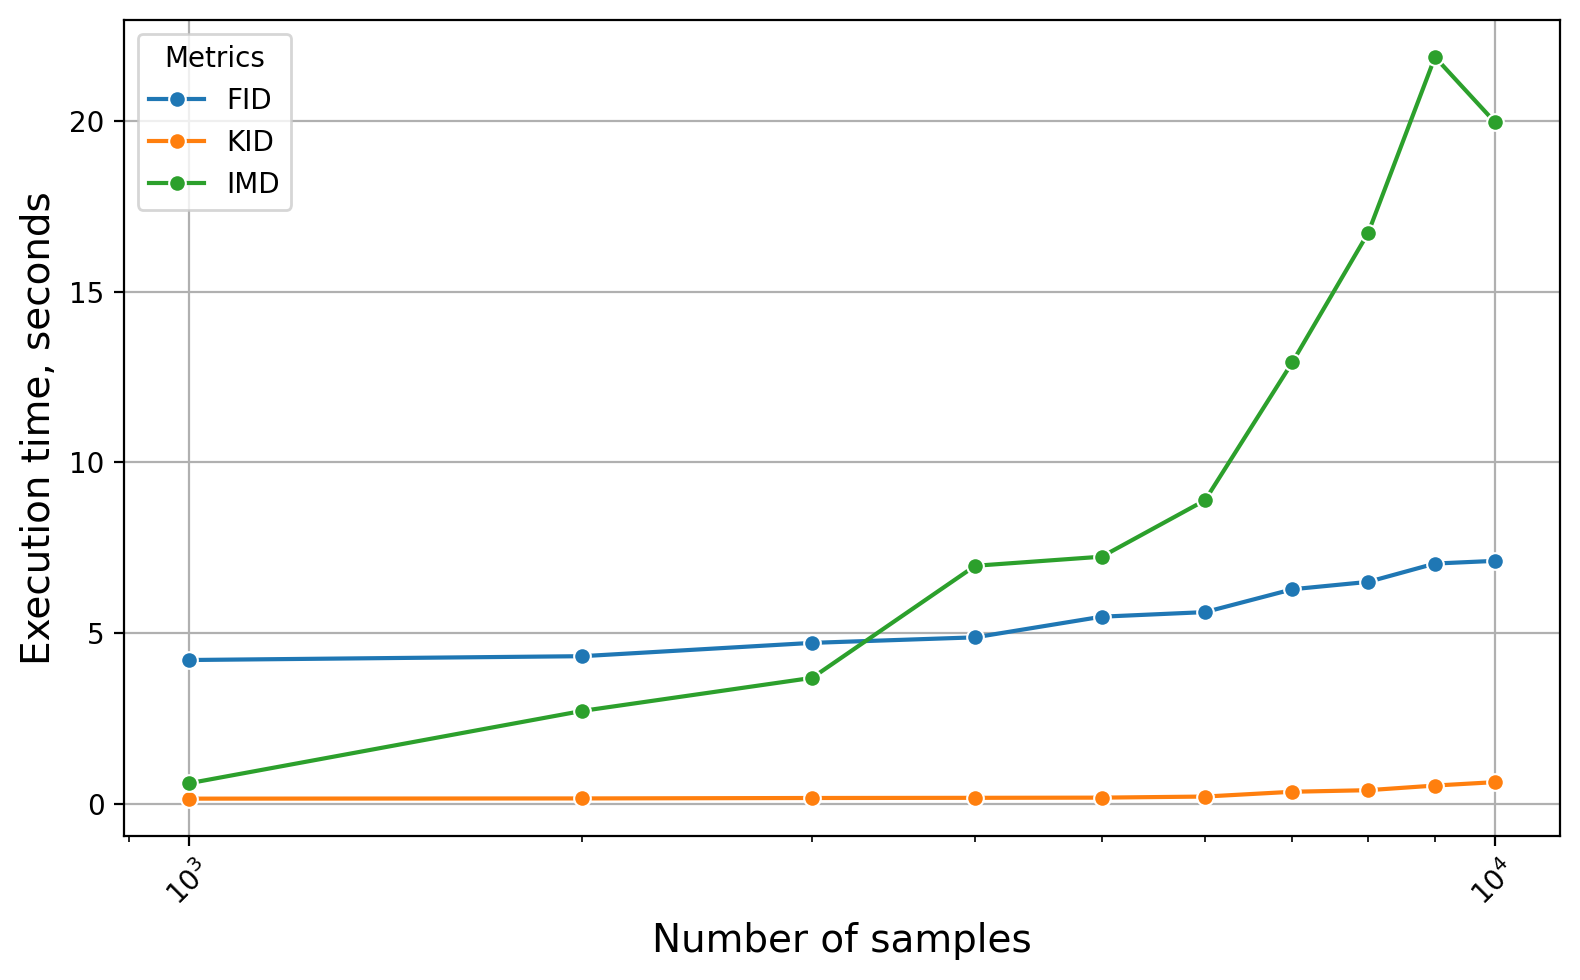

In [90]:
plt.figure(figsize=(8, 5), dpi=200)

sns.lineplot(x=num_batches*100, y=np.array(metric_time["FID"]), label='FID', marker='o')
sns.lineplot(x=num_batches*100, y=np.array(metric_time["KID"]), label='KID', marker='o')
sns.lineplot(x=num_batches*100, y=np.array(metric_time["MSID"]), label='IMD', marker='o')

# plt.title('Dependencies of FID, KID, IMD Metrics', fontsize=16)
plt.xlabel('Number of samples', fontsize=14)
plt.ylabel('Execution time, seconds', fontsize=14)
plt.xscale('log')
plt.legend(title='Metrics')
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.savefig('time_dependency_plot.png', dpi=300)
plt.show(); plt.close()

In [50]:
metric_dict_train

[{'FID': 271.4487, 'KID': 0.9642, 'MSID': 35.3937},
 {'FID': 268.3485, 'KID': 0.9829, 'MSID': 29.5988},
 {'FID': 267.7017, 'KID': 0.986, 'MSID': 26.1608},
 {'FID': 267.6953, 'KID': 0.9833, 'MSID': 26.0902},
 {'FID': 268.061, 'KID': 0.9865, 'MSID': 26.7561},
 {'FID': 268.4839, 'KID': 0.9888, 'MSID': 25.5099},
 {'FID': 268.2661, 'KID': 0.9886, 'MSID': 23.8066},
 {'FID': 268.4253, 'KID': 0.9893, 'MSID': 22.8654},
 {'FID': 268.2401, 'KID': 0.9883, 'MSID': 22.3707},
 {'FID': 268.2868, 'KID': 0.9888, 'MSID': 21.6359},
 {'FID': 268.4557, 'KID': 0.9904, 'MSID': 21.8244}]

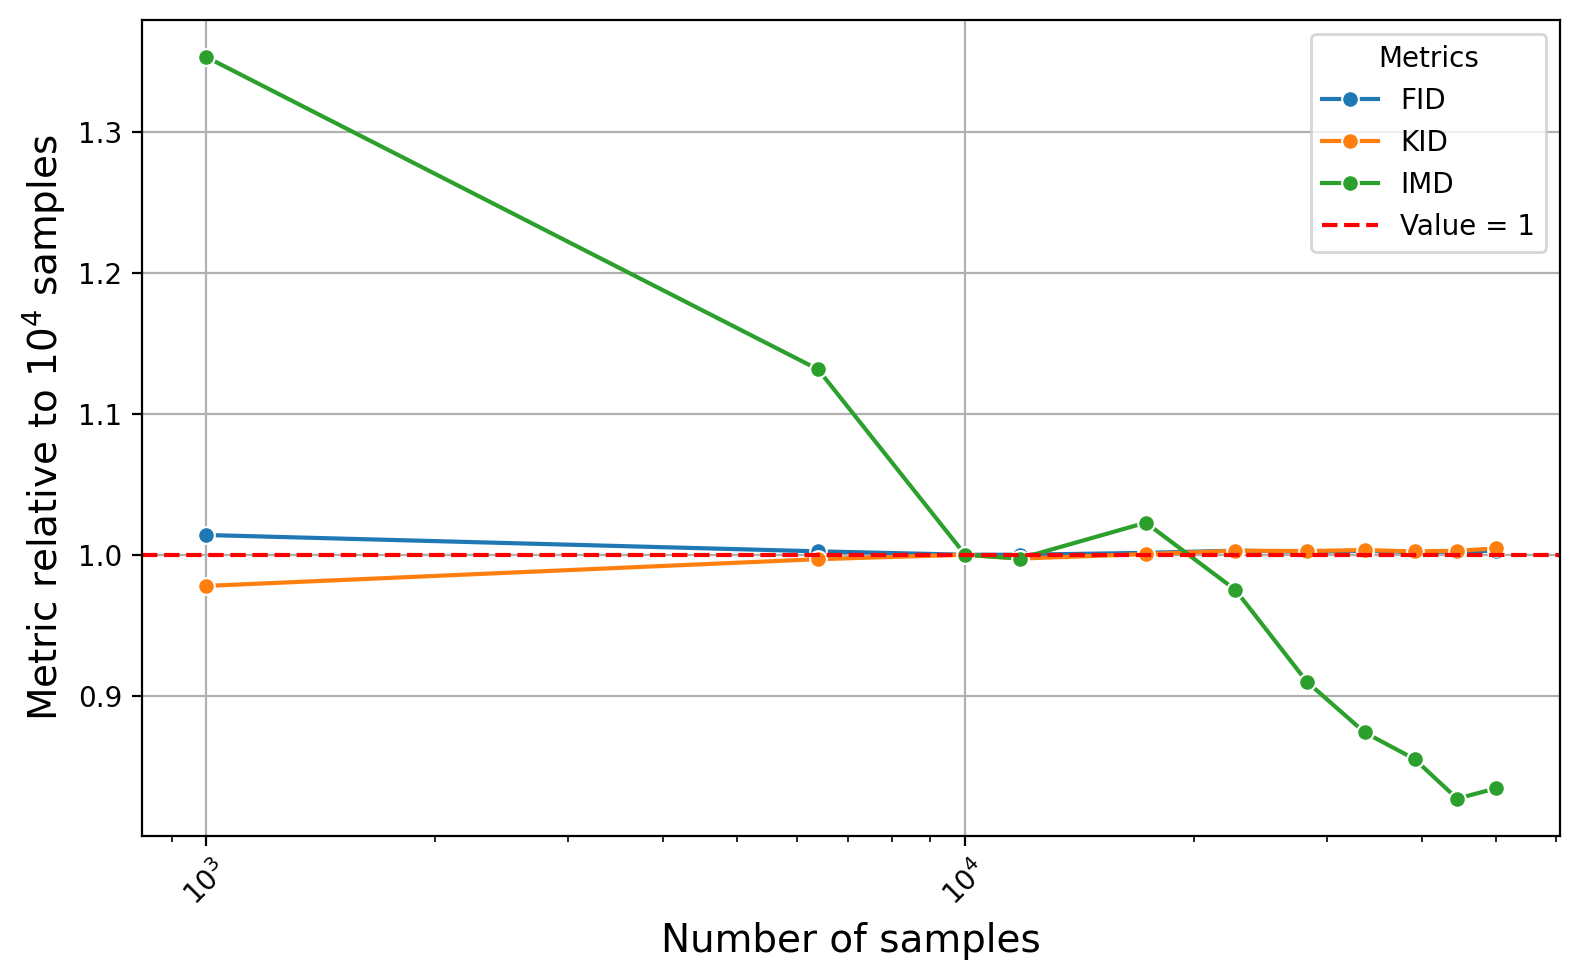

In [52]:
plt.figure(figsize=(8, 5), dpi=200)

sns.lineplot(x=num_batches_train*100, y=np.array(metric_dict_train["FID"]) / metric_dict_train["FID"][2], label='FID', marker='o')
sns.lineplot(x=num_batches_train*100, y=np.array(metric_dict_train["KID"]) / metric_dict_train["KID"][2], label='KID', marker='o')
sns.lineplot(x=num_batches_train*100, y=np.array(metric_dict_train["MSID"]) / metric_dict_train["MSID"][2], label='IMD', marker='o')

plt.axhline(y=1, color='r', linestyle='--', label='Value = 1')

# plt.title('Dependencies of FID, KID, IMD Metrics', fontsize=16)
plt.xlabel('Number of samples', fontsize=14)
plt.ylabel('Metric relative to $10^4$ samples', fontsize=14)
plt.xscale('log')
plt.legend(title='Metrics')
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.savefig('metrics_dependency_plot_train.png', dpi=300)
plt.show(); plt.close()